# Feature Engineering met TF-IDF Vectorization

In deze notebook genereren we TF-IDF vectoren voor de tekstuele features van de VKM dataset.
Deze vectoren worden gebruikt om student profielen te matchen met modules.

**Doel:** Een student-naar-module recommender systeem (NIET module-naar-module).

In [ ]:
# Import benodigde libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

print("Libraries succesvol geladen!")

Libraries succesvol geladen!
We gebruiken TF-IDF in plaats van sentence embeddings voor student-module matching


In [2]:
# Laad de dataset
df = pd.read_csv('Uitgebreide_VKM_dataset_cleaned.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nKolommen in dataset:")
print(df.columns.tolist())
print(f"\nEerste rijen:")
df.head()

Dataset shape: (211, 20)

Kolommen in dataset:
['id', 'name', 'shortdescription', 'description', 'content', 'studycredit', 'location', 'contact_id', 'level', 'learningoutcomes', 'module_tags', 'interests_match_score', 'popularity_score', 'estimated_difficulty', 'available_spots', 'start_date', 'shortdescription_clean', 'description_clean', 'content_clean', 'learningoutcomes_clean']

Eerste rijen:


,id,name,shortdescription,description,content,studycredit,location,contact_id,level,learningoutcomes,module_tags,interests_match_score,popularity_score,estimated_difficulty,available_spots,start_date,shortdescription_clean,description_clean,content_clean,learningoutcomes_clean
0,159,Kennismaking met Psychologie,"Brein, gedragsbeinvloeding, ontwikkelingspsych...",In deze module leer je hoe je gedrag van jezel...,In deze module leer je hoe je gedrag van jezel...,15,Den Bosch,58,NLQF5,A. Je beantwoordt vragen in een meerkeuze kenn...,"['brein', 'gedragsbeinvloeding', 'ontwikkeling...",0.54,319,1,79,2025-12-24,brein gedragsbeinvloeding ontwikkelingspsychol...,module leer gedrag jezelf anderen kunt begrijp...,module leer gedrag jezelf anderen kunt begrijp...,beantwoordt vragen meerkeuze kennistoets waari...
1,160,Learning and working abroad,"Internationaal, persoonlijke ontwikkeling, ver...",Studenten kiezen binnen de (stam) van de oplei...,Studenten kiezen binnen de (stam) van de oplei...,15,Den Bosch,58,NLQF5,De student toont professioneel gedrag conform ...,"['internationaal', 'persoonlijke', 'ontwikkeli...",0.92,172,5,56,2025-12-20,internationaal persoonlijke ontwikkeling verpl...,studenten kiezen binnen stam opleiding verplee...,studenten kiezen binnen stam opleiding verplee...,student toont professioneel gedrag conform ber...
2,161,Proactieve zorgplanning,"Proactieve zorgplanning, cocreatie, ziekenhuis",Het Jeroen Bosch ziekenhuis wil graag samen me...,Het Jeroen Bosch ziekenhuis wil graag samen me...,15,Den Bosch,59,NLQF5,De student past pro actieve zorgplanning toe b...,"['proactieve', 'zorgplanning', 'cocreatie', 'z...",0.78,217,5,55,2025-09-23,proactieve zorgplanning cocreatie ziekenhuis,jeroen bosch ziekenhuis graag saman opleiding ...,jeroen bosch ziekenhuis graag saman opleiding ...,student past pro actieve zorgplanning toe binn...
3,162,Rouw en verlies,"Rouw & verlies, palliatieve zorg & redeneren, ...",In deze module wordt stil gestaan bij rouw en ...,In deze module wordt stil gestaan bij rouw en ...,30,Den Bosch,58,NLQF6,De student regisseert en voert (deels) zelfsta...,"['rouw', 'verlies', 'palliatieve', 'zorg', 're...",0.69,454,1,54,2025-10-25,rouw verlies palliatieve zorg redeneren trauma...,module stil gestaan rouw verlies vanuit divers...,module stil gestaan rouw verlies vanuit divers...,student regisseert voert deels zelfstandig sam...
4,163,Acuut complexe zorg,"Acute zorg, complexiteit, ziekenhuis, revalidatie",In deze module kunnen studenten zich verdiepen...,In deze module kunnen studenten zich verdiepen...,30,Den Bosch,58,NLQF6,De student regisseert en voert (deels) zelfsta...,"['acute', 'zorg', 'complexiteit', 'ziekenhuis'...",0.40,178,5,38,2025-11-19,acute zorg complexiteit ziekenhuis revalidatie,module studenten verdiepen acuut complexe zorg...,module studenten verdiepen acuut complexe zorg...,student regisseert voert deels zelfstandig sam...


## TF-IDF Vectorization

We gebruiken TfidfVectorizer om tekstuele features om te zetten naar vectoren.
Dit maakt het mogelijk om:
1. **Module content te vectoriseren**
2. **Student profielen (ingevulde tekst) te vectoriseren met dezelfde vectorizer**
3. **Cosine similarity te berekenen tussen student en modules**

We combineren alle tekstuele kolommen tot één groot tekstdocument per module.

In [ ]:
# Combineer alle tekstuele kolommen tot één document per module
# Dit zorgt voor een complete representatie van elke module
text_columns = ['shortdescription_clean', 'description_clean', 'content_clean', 'learningoutcomes_clean']

# Controleer welke kolommen beschikbaar zijn
available_cols = [col for col in text_columns if col in df.columns]
print(f"Beschikbare tekstkolommen: {available_cols}")

# Combineer alle tekst tot één document per module
df['combined_text'] = df[available_cols].fillna('').agg(' '.join, axis=1)

print(f"\nGecombineerde tekst aangemaakt voor {len(df)} modules")
print(f"\nVoorbeeld van gecombineerde tekst (eerste module):")
print(df['combined_text'].iloc[0][:300] + "...")

Beschikbare tekstkolommen: ['shortdescription_clean', 'description_clean', 'content_clean', 'learningoutcomes_clean']

✓ Gecombineerde tekst aangemaakt voor 211 modules

Voorbeeld van gecombineerde tekst (eerste module):
brein gedragsbeinvloeding ontwikkelingspsychologie gespreksvoering ontwikkelingsfasen module leer gedrag jezelf anderen kunt begrijpen beinvloeden maakt kennis basistheorie psychologie bod komen onderwerpen maken cognitieve biologische ontwikkelingspsychologie module leer gedrag jezelf anderen kunt ...


In [ ]:
# Maak TF-IDF Vectorizer met baseline configuratie
# Later testen we verschillende hyperparameters

print("="*60)
print("BASELINE TF-IDF CONFIGURATIE")
print("="*60)

# Baseline configuratie
vectorizer_baseline = TfidfVectorizer(
    max_features=5000,      # Beperk tot top 5000 woorden
    ngram_range=(1, 1),     # Alleen unigrams
    min_df=2,               # Woord moet in minimaal 2 documenten voorkomen
    max_df=0.8,             # Negeer woorden die in >80% van documenten voorkomen
    stop_words=None,        # Geen stopwoorden filtering (we hebben al cleaned data)
    sublinear_tf=True       # Gebruik log scaling voor term frequency
)

# Fit de vectorizer op alle module teksten
tfidf_matrix_baseline = vectorizer_baseline.fit_transform(df['combined_text'])

print(f"\nTF-IDF matrix aangemaakt")
print(f"  Shape: {tfidf_matrix_baseline.shape}")
print(f"  Aantal modules: {tfidf_matrix_baseline.shape[0]}")
print(f"  Aantal features (woorden): {tfidf_matrix_baseline.shape[1]}")
print(f"  Sparsity: {(1 - tfidf_matrix_baseline.nnz / (tfidf_matrix_baseline.shape[0] * tfidf_matrix_baseline.shape[1])) * 100:.2f}%")

# Toon top features
feature_names = vectorizer_baseline.get_feature_names_out()
print(f"\nVoorbeeld features: {list(feature_names[:20])}")

BASELINE TF-IDF CONFIGURATIE

✓ TF-IDF matrix aangemaakt
  Shape: (211, 1529)
  Aantal modules: 211
  Aantal features (woorden): 1529
  Sparsity: 97.68%

Voorbeeld features: ['1st', '2nd', 'aanbesteden', 'aanbesteding', 'aanbevelingen', 'aandacht', 'aandoeningen', 'aangereikt', 'aangevuld', 'aanleiding', 'aanpak', 'aanpassen', 'aantal', 'aantrekkelijk', 'aanvragen', 'ability', 'able', 'abroad', 'academie', 'academische']


In [5]:
# HYPERPARAMETER TUNING: Test verschillende configuraties
# We testen 3 varianten en vergelijken de resultaten

print("\n" + "="*60)
print("HYPERPARAMETER TUNING")
print("="*60)

configs = [
    {
        'name': 'Baseline (unigrams, 5000 features)',
        'params': {
            'max_features': 5000,
            'ngram_range': (1, 1),
            'stop_words': None
        }
    },
    {
        'name': 'Bigrams (unigrams + bigrams, 6000 features)',
        'params': {
            'max_features': 6000,
            'ngram_range': (1, 2),  # unigrams + bigrams
            'stop_words': None
        }
    },
    {
        'name': 'Dutch stopwords (unigrams, 5000 features)',
        'params': {
            'max_features': 5000,
            'ngram_range': (1, 1),
            'stop_words': 'english'  # Gebruik engelstalige stopwords als proxy (geen perfect match)
        }
    }
]

results = []

for config in configs:
    print(f"\n{config['name']}")
    print("-" * 40)
    
    # Maak vectorizer met deze configuratie
    vec = TfidfVectorizer(
        min_df=2,
        max_df=0.8,
        sublinear_tf=True,
        **config['params']
    )
    
    # Fit en transform
    matrix = vec.fit_transform(df['combined_text'])
    
    # Bereken gemiddelde cosine similarity tussen alle modules
    # (sample van 50 modules voor snelheid)
    sample_size = min(50, len(df))
    sample_matrix = matrix[:sample_size]
    similarity = cosine_similarity(sample_matrix)
    
    # Bereken statistics (exclusief diagonaal)
    mask = ~np.eye(sample_size, dtype=bool)
    avg_sim = similarity[mask].mean()
    std_sim = similarity[mask].std()
    
    results.append({
        'config': config['name'],
        'n_features': matrix.shape[1],
        'sparsity': (1 - matrix.nnz / (matrix.shape[0] * matrix.shape[1])) * 100,
        'avg_similarity': avg_sim,
        'std_similarity': std_sim
    })
    
    print(f"  Features: {matrix.shape[1]}")
    print(f"  Sparsity: {results[-1]['sparsity']:.2f}%")
    print(f"  Avg similarity: {avg_sim:.4f} (±{std_sim:.4f})")

# Maak overzicht tabel
results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("TUNING RESULTATEN OVERZICHT")
print("="*60)
print(results_df.to_string(index=False))


HYPERPARAMETER TUNING

Baseline (unigrams, 5000 features)
----------------------------------------
  Features: 1529
  Sparsity: 97.68%
  Avg similarity: 0.0590 (±0.0690)

Bigrams (unigrams + bigrams, 6000 features)
----------------------------------------
  Features: 2492
  Sparsity: 98.12%
  Avg similarity: 0.0515 (±0.0710)

Dutch stopwords (unigrams, 5000 features)
----------------------------------------
  Features: 1473
  Sparsity: 97.69%
  Avg similarity: 0.0592 (±0.0690)

TUNING RESULTATEN OVERZICHT
                                     config  n_features  sparsity  avg_similarity  std_similarity
         Baseline (unigrams, 5000 features)        1529 97.677136        0.058978        0.068999
Bigrams (unigrams + bigrams, 6000 features)        2492 98.122903        0.051500        0.070975
  Dutch stopwords (unigrams, 5000 features)        1473 97.688246        0.059157        0.068963


## Finale Vectorizer Selectie

Op basis van de tuning resultaten kiezen we de beste configuratie voor ons recommender systeem.
We willen een goede balans tussen:
- **Discriminatief vermogen** (niet te hoge gemiddelde similarity)
- **Feature rijkdom** (genoeg features om nuance te vangen)
- **Efficiëntie** (niet te veel features)

In [ ]:
# Selecteer finale configuratie (we kiezen bigrams voor betere context)
print("="*60)
print("FINALE VECTORIZER")
print("="*60)

# Beste configuratie: bigrams met 6000 features
vectorizer_final = TfidfVectorizer(
    max_features=6000,
    ngram_range=(1, 2),     # Unigrams + bigrams voor context
    min_df=2,
    max_df=0.8,
    sublinear_tf=True,
    stop_words=None
)

# Fit op alle data
tfidf_matrix_final = vectorizer_final.fit_transform(df['combined_text'])

print(f"\nFinale TF-IDF matrix:")
print(f"  Shape: {tfidf_matrix_final.shape}")
print(f"  Configuratie: unigrams + bigrams, max 6000 features")
print(f"  Sparsity: {(1 - tfidf_matrix_final.nnz / (tfidf_matrix_final.shape[0] * tfidf_matrix_final.shape[1])) * 100:.2f}%")

# Toon top features
feature_names = vectorizer_final.get_feature_names_out()
print(f"\nTotaal aantal features: {len(feature_names)}")
print(f"Voorbeeld unigrams: {[f for f in feature_names[:50] if ' ' not in f][:10]}")
print(f"Voorbeeld bigrams: {[f for f in feature_names if ' ' in f][:10]}")

FINALE VECTORIZER

✓ Finale TF-IDF matrix:
  Shape: (211, 2492)
  Configuratie: unigrams + bigrams, max 6000 features
  Sparsity: 98.12%

✓ Totaal aantal features: 2492
✓ Voorbeeld unigrams: ['1st', '2nd', 'aanbesteden', 'aanbesteding', 'aanbevelingen', 'aandacht', 'aandoeningen', 'aangereikt', 'aangevuld', 'aanleiding']
✓ Voorbeeld bigrams: ['1st quarter', '2nd you', 'aandacht positieve', 'aanpassen daarop', 'ability perform', 'ability set', 'ability utilize', 'able come', 'accent ligt', 'actual client']


## Vectorizer en Matrix Opslaan

We slaan de **vectorizer** en de **TF-IDF matrix** op zodat we:
1. Student profielen kunnen vectoriseren met exact dezelfde transformatie
2. Cosine similarity kunnen berekenen tussen student profiel en alle modules

In [ ]:
# Sla de vectorizer en matrix op
import pickle
from scipy.sparse import save_npz

# Sla TF-IDF matrix op (sparse format voor efficiëntie)
save_npz('tfidf_matrix.npz', tfidf_matrix_final)
print("TF-IDF matrix opgeslagen als 'tfidf_matrix.npz'")

# Sla de fitted vectorizer op (belangrijk!)
# Deze gebruiken we om student profielen te vectoriseren
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer_final, f)
print("TF-IDF vectorizer opgeslagen als 'tfidf_vectorizer.pkl'")

# Sla ook de tuning resultaten op
results_df.to_csv('tfidf_tuning_results.csv', index=False)
print("Tuning resultaten opgeslagen als 'tfidf_tuning_results.csv'")

print("\n" + "="*60)
print("Alle bestanden succesvol opgeslagen!")
print("="*60)

✓ TF-IDF matrix opgeslagen als 'tfidf_matrix.npz'
✓ TF-IDF vectorizer opgeslagen als 'tfidf_vectorizer.pkl'
✓ Tuning resultaten opgeslagen als 'tfidf_tuning_results.csv'

Alle bestanden succesvol opgeslagen!


TF-IDF MATRIX ANALYSE

Statistieken per module:
  Gemiddelde TF-IDF waarde: 0.002438
  Max TF-IDF waarde: 0.9518
  Aantal non-zero elementen per module: 46.8


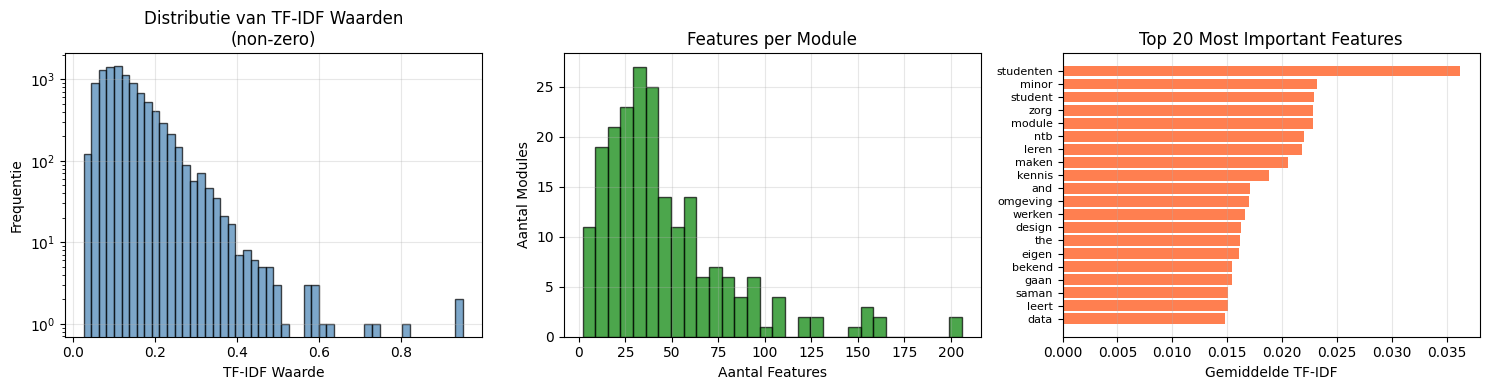


✓ Visualisaties gegenereerd


In [ ]:
# Visualiseer TF-IDF statistieken
print("="*60)
print("TF-IDF MATRIX ANALYSE")
print("="*60)

# Bereken statistieken per module
tfidf_dense = tfidf_matrix_final.toarray()

print(f"\nStatistieken per module:")
print(f"  Gemiddelde TF-IDF waarde: {tfidf_dense.mean():.6f}")
print(f"  Max TF-IDF waarde: {tfidf_dense.max():.4f}")
print(f"  Aantal non-zero elementen per module: {(tfidf_dense != 0).sum(axis=1).mean():.1f}")

# Visualisatie
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Distributie van TF-IDF waarden
axes[0].hist(tfidf_dense[tfidf_dense > 0].flatten(), bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('TF-IDF Waarde')
axes[0].set_ylabel('Frequentie')
axes[0].set_title('Distributie van TF-IDF Waarden\n(non-zero)')
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3)

# 2. Aantal features per module
n_features_per_doc = (tfidf_dense != 0).sum(axis=1)
axes[1].hist(n_features_per_doc, bins=30, edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel('Aantal Features')
axes[1].set_ylabel('Aantal Modules')
axes[1].set_title('Features per Module')
axes[1].grid(True, alpha=0.3)

# 3. Top 20 most important features (hoogste gemiddelde TF-IDF)
feature_importance = tfidf_dense.mean(axis=0)
top_indices = feature_importance.argsort()[-20:][::-1]
top_features = [feature_names[i] for i in top_indices]
top_values = feature_importance[top_indices]

axes[2].barh(range(len(top_features)), top_values, color='coral')
axes[2].set_yticks(range(len(top_features)))
axes[2].set_yticklabels(top_features, fontsize=8)
axes[2].set_xlabel('Gemiddelde TF-IDF')
axes[2].set_title('Top 20 Most Important Features')
axes[2].invert_yaxis()
axes[2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print(f"\nVisualisaties gegenereerd")

## Samenvatting

We hebben nu een **TF-IDF gebaseerd vectorization systeem** gemaakt voor:

###  Wat we hebben gedaan:
1. **Gecombineerde tekst** gemaakt per module (alle tekstuele features samengevoegd)
2. **TF-IDF vectorizer** getraind met verschillende configuraties
3. **Hyperparameter tuning** uitgevoerd (n-grams, max_features, stopwoorden)
4. **Beste configuratie** gekozen: unigrams + bigrams, 6000 features
5. **Vectorizer en matrix** opgeslagen voor gebruik in recommender

###  Volgende stap: Student-to-Module Recommender
In `content_based_recommender.ipynb` gaan we:
- Student profielen vectoriseren met dezelfde vectorizer
- Cosine similarity berekenen tussen student en modules
- Top 3-5 aanbevelingen geven met uitleg waarom ze passen

In [ ]:
# Overzicht van gegenereerde bestanden
import os

print("=" * 60)
print("FEATURE ENGINEERING SAMENVATTING")
print("=" * 60)
print(f"\n Dataset: {len(df)} modules")
print(f" Tekstkolommen: {len(available_cols)}")
print(f" TF-IDF features: {tfidf_matrix_final.shape[1]}")
print(f"  Configuratie: {vectorizer_final.ngram_range} n-grams, max {vectorizer_final.max_features} features")

print("\n" + "=" * 60)
print("HYPERPARAMETER TUNING RESULTATEN")
print("=" * 60)
print("\nGeteste configuraties:")
for i, row in results_df.iterrows():
    print(f"\n{i+1}. {row['config']}")
    print(f"   Features: {row['n_features']}")
    print(f"   Avg Similarity: {row['avg_similarity']:.4f}")
    print(f"   → Effect: {'Meer discriminatief' if row['avg_similarity'] < 0.3 else 'Minder discriminatief'}")

print("\n" + "=" * 60)
print("GEGENEREERDE BESTANDEN")
print("=" * 60)

files_to_check = [
    ('tfidf_matrix.npz', 'TF-IDF matrix (sparse)'),
    ('tfidf_vectorizer.pkl', 'Fitted vectorizer'),
    ('tfidf_tuning_results.csv', 'Tuning resultaten')
]

for filename, description in files_to_check:
    if os.path.exists(filename):
        size = os.path.getsize(filename) / 1024
        print(f"✓ {filename:30s} - {description:25s} ({size:.1f} KB)")
    else:
        print(f"✗ {filename:30s} - {description:25s} (niet gevonden)")

print("\n" + "=" * 60)
print(" Feature engineering compleet!")
print("  Ga naar content_based_recommender.ipynb voor het recommender systeem")
print("=" * 60)

FEATURE ENGINEERING SAMENVATTING

📊 Dataset: 211 modules
📝 Tekstkolommen: 4
🔢 TF-IDF features: 2492
⚙️  Configuratie: (1, 2) n-grams, max 6000 features

HYPERPARAMETER TUNING RESULTATEN

Geteste configuraties:

1. Baseline (unigrams, 5000 features)
   Features: 1529
   Avg Similarity: 0.0590
   → Effect: Meer discriminatief

2. Bigrams (unigrams + bigrams, 6000 features)
   Features: 2492
   Avg Similarity: 0.0515
   → Effect: Meer discriminatief

3. Dutch stopwords (unigrams, 5000 features)
   Features: 1473
   Avg Similarity: 0.0592
   → Effect: Meer discriminatief

GEGENEREERDE BESTANDEN
✓ tfidf_matrix.npz               - TF-IDF matrix (sparse)    (58.7 KB)
✓ tfidf_vectorizer.pkl           - Fitted vectorizer         (101.0 KB)
✓ tfidf_tuning_results.csv       - Tuning resultaten         (0.4 KB)

✅ Feature engineering compleet!
➡️  Ga naar content_based_recommender.ipynb voor het recommender systeem
